# Diabetes Dataset

In [1]:
from Functions import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
import scipy
from scipy.linalg import pinv
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, train_test_split, validation_curve, GridSearchCV, learning_curve
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import warnings
import time

warnings.filterwarnings('ignore')
# pd.set_option('max_columns', None)

In [3]:
df = pd.read_csv('data/diabetes_train.csv').drop('Unnamed: 0', axis=1)
target_col = 'Diabetes'
X = scale(df.drop(target_col, axis=1))
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
kf = KFold(5)

# k-Means

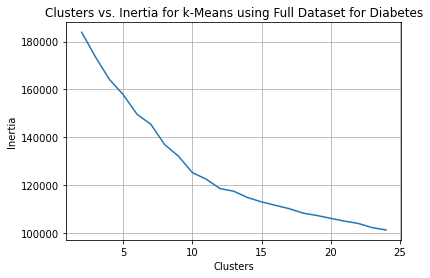

In [4]:
s_scores = plot_inertia(X, 'Full Dataset', target_col, split=True)

> **intertia**: Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

>A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases.

>To find the optimal K for a dataset, use the Elbow method; find the point where the decrease in inertia begins to slow

[source](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet)

### Plotting Silhouette Scores

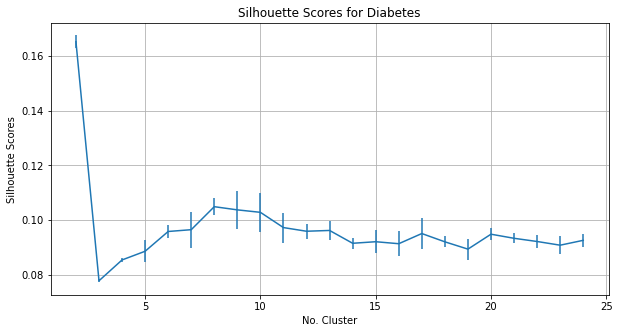

In [5]:
s_scores_df = pd.DataFrame(s_scores)
fig, ax = plt.subplots(figsize=(10,5))
s_avgs = s_scores_df.groupby('cluster').mean()
ax.errorbar(s_avgs.index, s_avgs['silhouette score'], yerr=s_scores_df.groupby('cluster').std()['silhouette score'])
ax.set_title(f'Silhouette Scores for {target_col}')
ax.set_ylabel('Silhouette Scores')
ax.set_xlabel('No. Cluster')
ax.grid();

> **silhouette score**: The value of the silhouette *coefﬁcient* is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Inertia          :  166566.99955819795
Silhouette score :  0.11089463284217606
AMI score        :  0.09393579589545296
Cluster 0:
	True  : 75.0%
	False : 25.0%
Cluster 1:
	True  : 18.0%
	False : 82.0%
Cluster 2:
	True  : 58.0%
	False : 42.0%
Cluster 3:
	True  : 47.0%
	False : 53.0%
Cluster 4:
	True  : 64.0%
	False : 36.0%
Cluster 5:
	True  : 78.0%
	False : 22.0%
Cluster 6:
	True  : 27.0%
	False : 73.0%
Cluster 7:
	True  : 7.0%
	False : 93.0%


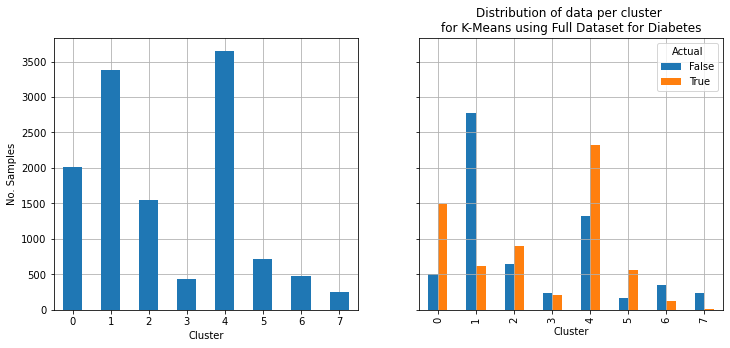

In [6]:
kmeans_cluster = plot_kmeans_cluster_dist(8, X, y, 'Full Dataset', target_col);
get_cluster_breakdown(kmeans_cluster.labels_, y)

Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. For two clusterings  and , the AMI is given as:

$AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [avg(H(U), H(V)) - E(MI(U, V))]$
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching  (label_true) with  (labels_pred) will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.
[sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

# GMM

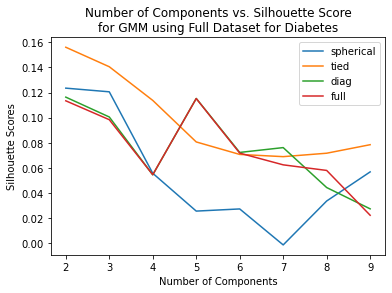

In [7]:
min_comps, max_comps = 2, 10
best_gmm, bic = run_gmm(X, n_comps=range(min_comps,max_comps))
plot_bic(bic, 'GMM', data_set='Full Dataset', target_col=target_col, n_comps=range(min_comps,max_comps))

Silhouette score :  0.15614376318508408
AMI score        :  0.06340617721464664


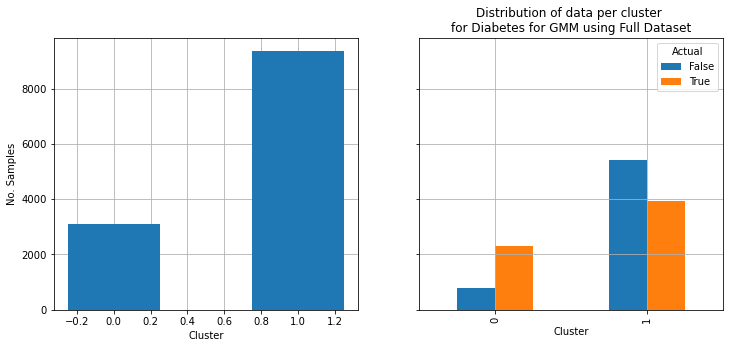

In [8]:
plot_cluster_dist(best_gmm, X, y, 'GMM', 'Full Dataset', target_col)

# PCA

PCA is designed for continuous variables. It tries to minimize variance (=squared deviations). The concept of squared deviations breaks down when you have binary variables.

In [9]:
pca = PCA(random_state=0)
pca.fit(X);

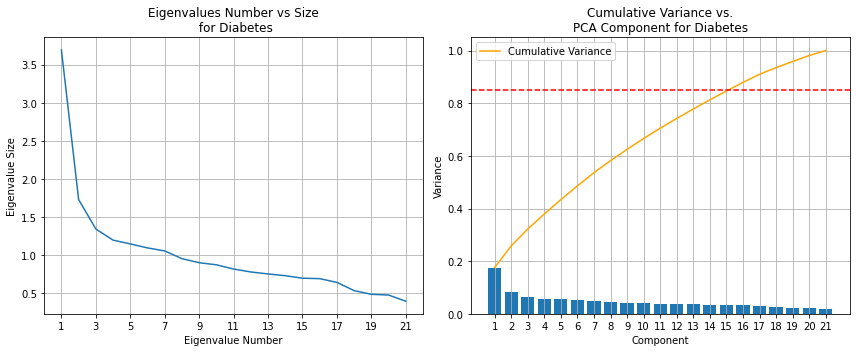

In [11]:
plot_pca_variance(pca, target_col)

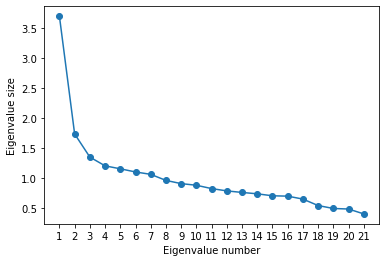

In [12]:
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.xticks(range(len(pca.explained_variance_)), range(1, len(pca.explained_variance_)+1));

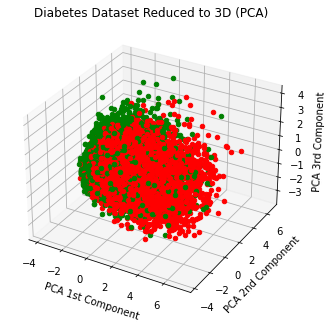

In [13]:
X_PCA = PCA(n_components = .85).fit_transform(X)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.3, random_state=0)
plot_3d(X_PCA, y, target_col=target_col, dataset='PCA')

# ICA

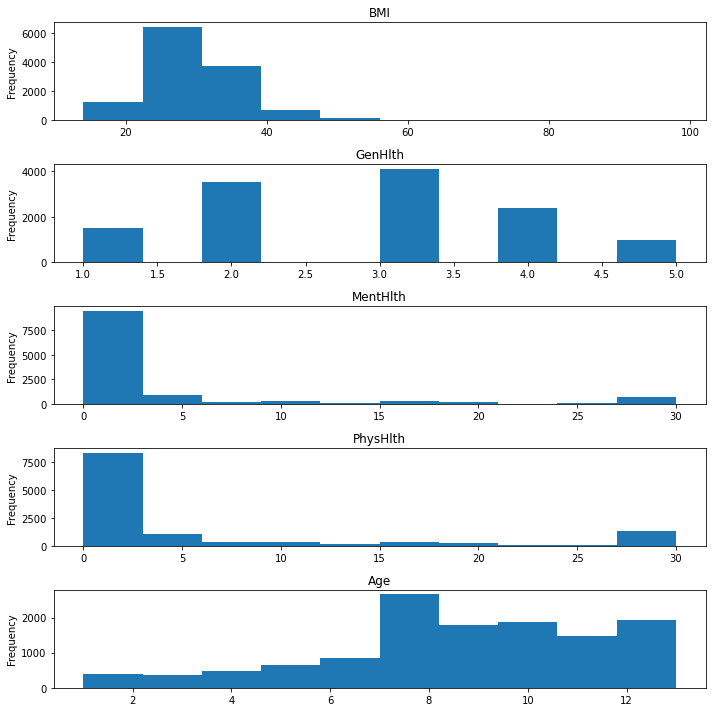

In [14]:
fig, ax = plt.subplots(5, figsize=(10,10))
i=0
for col in df.columns:
    try:
        df[col].plot.hist(ax=ax[i], title=col)
        i+=1
    except:pass
plt.tight_layout()

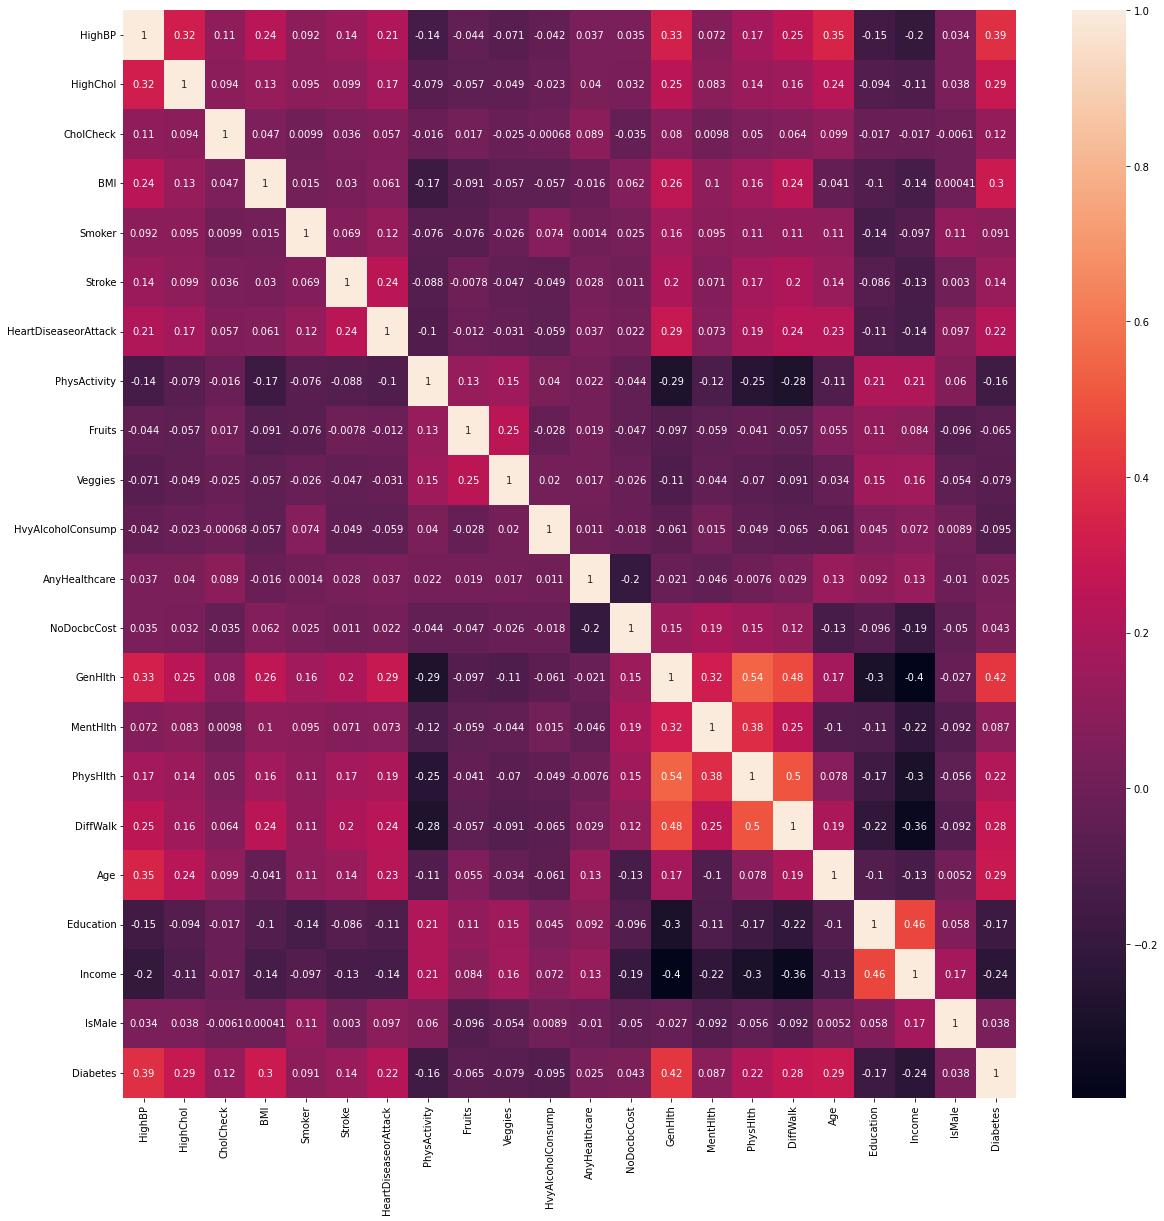

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, ax=ax);

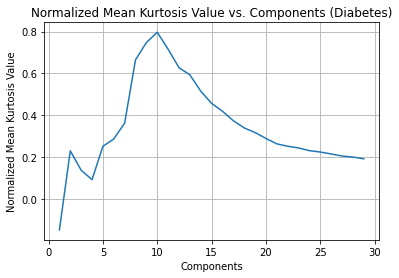

In [16]:
kurtosis_values = plot_kurtosis_values(X, target_col=target_col)

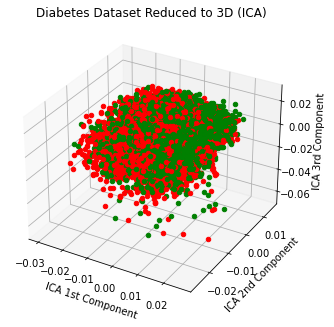

In [17]:
X_ICA = FastICA(n_components = np.argmax(kurtosis_values)+1).fit_transform(X)
X_ICA_train, X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA, y, test_size=0.3, random_state=0)
plot_3d(X_ICA, y, target_col=target_col, dataset='ICA')

# Randomized Projections

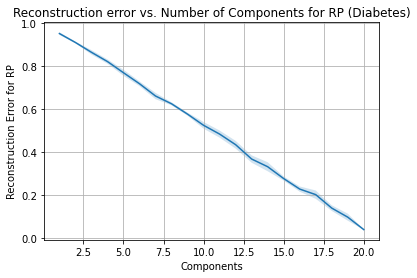

In [18]:
re = []
rv = []
for i in range(1,X.shape[1]):
    mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(X_train)
        w = X_RP.components_
        r = ((pinv(w)@w)@(X_train.T)).T
        mse.append(mean_squared_error(X_train,r))
    rv.append(np.std(mse))
    re.append(np.mean(mse))

re = np.array(re)
plt.plot(range(1, X.shape[1]),re)
plt.fill_between(range(1, X.shape[1]),re - rv, re + rv, alpha=0.2)
plt.xlabel('No. Components')
plt.ylabel('Reconstruction Error for RP')
plt.title(f'Reconstruction Error vs. No. Components for RP {target_col}')
plt.grid()

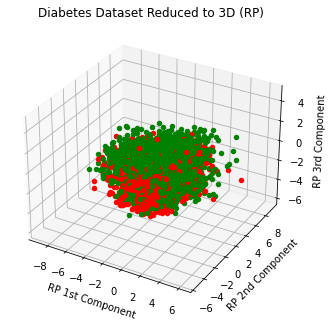

In [19]:
X_RP = GaussianRandomProjection(n_components = 10).fit_transform(X)
X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.3, random_state=0)
plot_3d(X_RP, y, target_col=target_col, dataset='RP')

# Feature Selection (Decision Tree)

Features selected: ['HighBP', 'BMI', 'GenHlth', 'PhysHlth', 'Age', 'Education', 'Income']


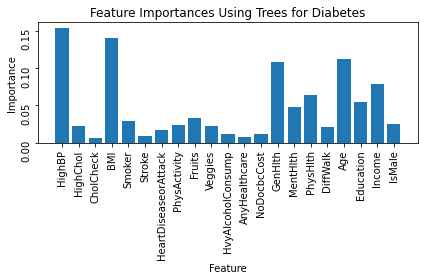

In [20]:
X_df = pd.DataFrame(X, columns=df.drop(target_col, axis=1).columns)

dt = DecisionTreeClassifier()
dt = dt.fit(X_df,y)
model = SelectFromModel(dt, prefit=True)
X_tree = model.transform(X_df)
feats = model.get_feature_names_out(X_df.columns)
print(f'Features selected: {[feat for feat in feats]}')
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.3, random_state=0)
plt.bar(df.drop(target_col, axis=1).columns, dt.feature_importances_)
plt.xticks(range(df.shape[1]-1), df.drop(target_col, axis=1).columns)
plt.tick_params(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Feature Importances Using Trees for {target_col}')
plt.tight_layout();

# Clustering with Dimensionality Reduction
## k-Means

Inertia          :  185751.0077056978
Silhouette score :  0.09239793803542146
AMI score        :  0.14079184882568505
Cluster 0:
	True  : 76.0%
	False : 24.0%
Cluster 1:
	True  : 63.0%
	False : 37.0%
Cluster 2:
	True  : 18.0%
	False : 82.0%


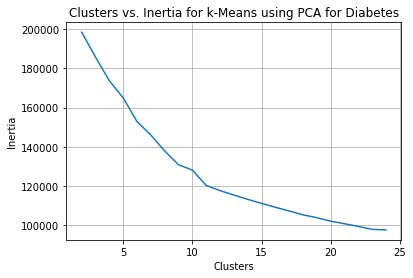

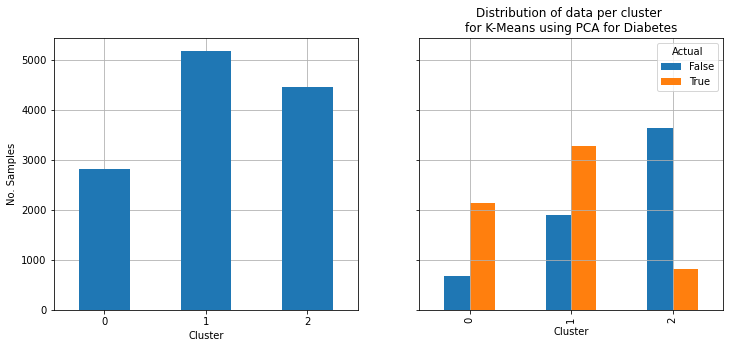

In [21]:
data_set = 'PCA'
plot_inertia(X_PCA, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(3, X_PCA, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  5.738956695096971
Silhouette score :  0.14692573254449992
AMI score        :  0.03017662451991669
Cluster 0:
	True  : 46.0%
	False : 54.0%
Cluster 1:
	True  : 56.0%
	False : 44.0%
Cluster 2:
	True  : 39.0%
	False : 61.0%
Cluster 3:
	True  : 27.0%
	False : 73.0%
Cluster 4:
	True  : 77.0%
	False : 23.0%
Cluster 5:
	True  : 57.0%
	False : 43.0%
Cluster 6:
	True  : 7.0%
	False : 93.0%


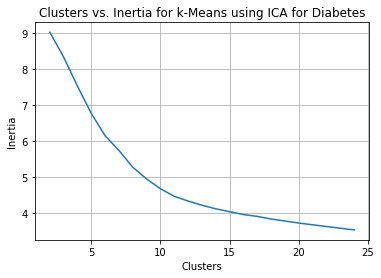

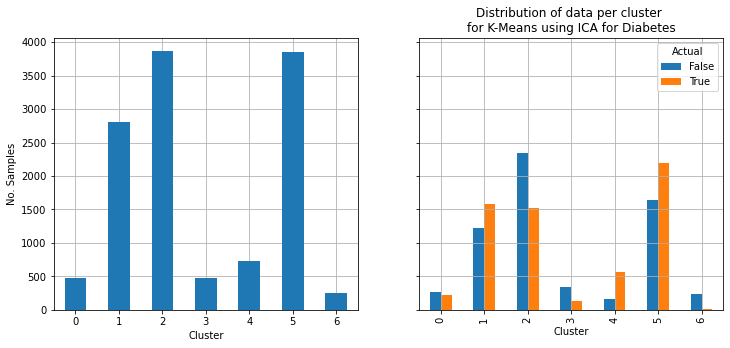

In [22]:
data_set = 'ICA'
plot_inertia(X_ICA, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(7, X_ICA, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  174140.59221934096
Silhouette score :  0.15197134259409814
AMI score        :  0.043354724443345205
Cluster 0:
	True  : 73.0%
	False : 27.0%
Cluster 1:
	True  : 36.0%
	False : 64.0%
Cluster 2:
	True  : 49.0%
	False : 51.0%
Cluster 3:
	True  : 63.0%
	False : 37.0%


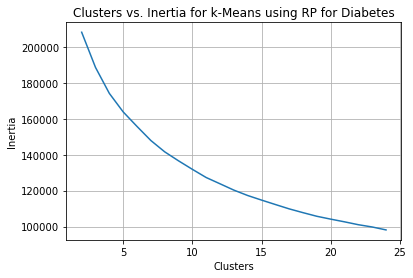

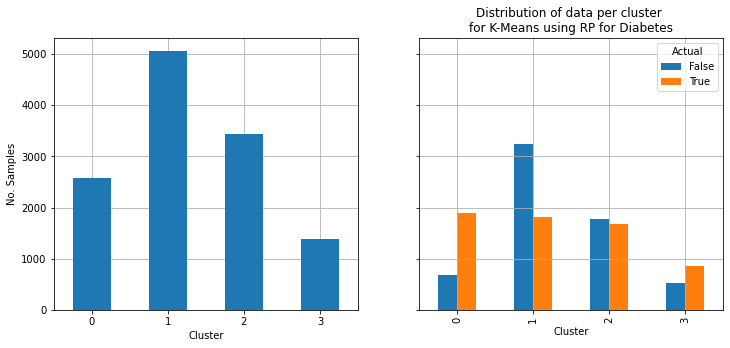

In [23]:
data_set = 'RP'
plot_inertia(X_RP, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(4, X_RP, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

Inertia          :  49654.16508247184
Silhouette score :  0.2125923230316593
AMI score        :  0.10107897770409419
Cluster 0:
	True  : 74.0%
	False : 26.0%
Cluster 1:
	True  : 69.0%
	False : 31.0%
Cluster 2:
	True  : 21.0%
	False : 79.0%
Cluster 3:
	True  : 59.0%
	False : 41.0%


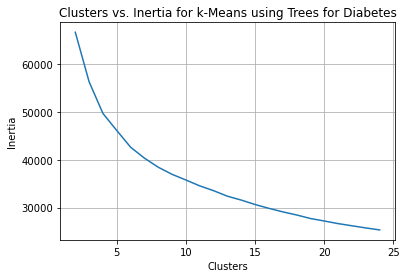

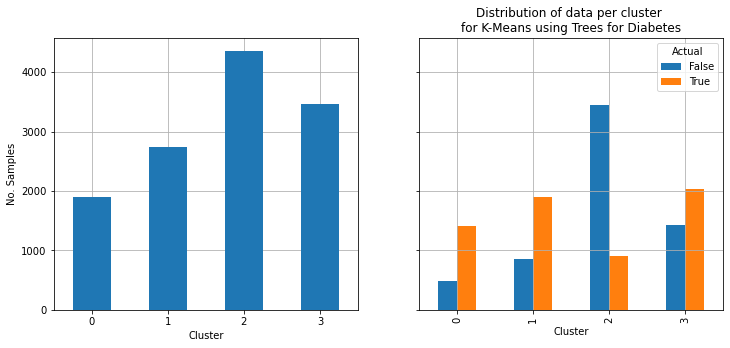

In [24]:
data_set = 'Trees'
plot_inertia(X_tree, data_set, target_col)

k_means_clustering = plot_kmeans_cluster_dist(4, X_tree, y, data_set, target_col)

get_cluster_breakdown(k_means_clustering.labels_, y)

## GMM

In [25]:
# pd.set_option('max_columns', 50)
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income,IsMale,Diabetes
0,False,False,True,32.0,False,False,False,True,True,True,...,False,3.0,1.0,2.0,False,6.0,5.0,6.0,False,False
1,False,False,True,24.0,True,False,False,True,True,True,...,False,2.0,0.0,0.0,False,7.0,6.0,8.0,True,False
2,True,True,True,35.0,True,False,False,False,True,True,...,True,5.0,0.0,3.0,True,9.0,5.0,3.0,False,True
3,False,False,True,19.0,False,False,False,True,True,True,...,False,1.0,0.0,0.0,False,9.0,6.0,8.0,False,False
4,True,True,True,49.0,True,False,False,True,True,True,...,False,2.0,0.0,0.0,False,9.0,6.0,7.0,True,True


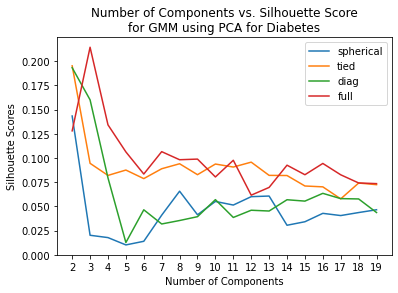

Silhouette score :  0.21432154649690396
AMI score        :  0.02492110813839117


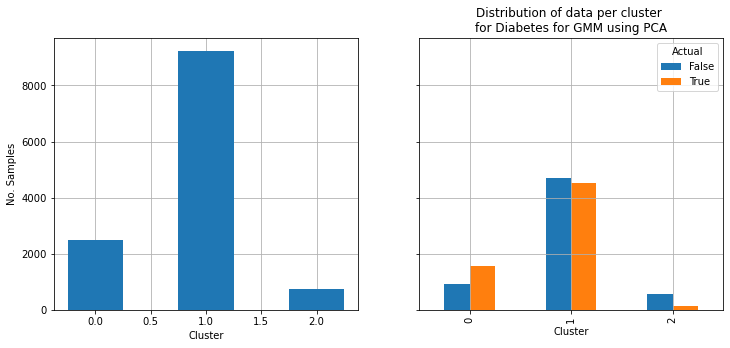

In [26]:
model_name = 'GMM'
data_set = 'PCA'

best_gmm, bic = run_gmm(X_PCA)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_PCA, y, model_name, data_set, target_col)

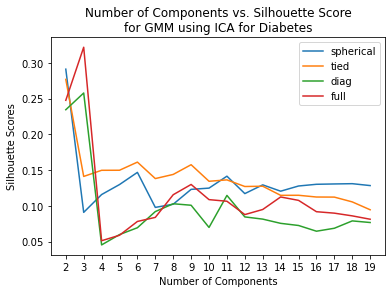

Silhouette score :  0.3218700174935199
AMI score        :  0.007109936525161247


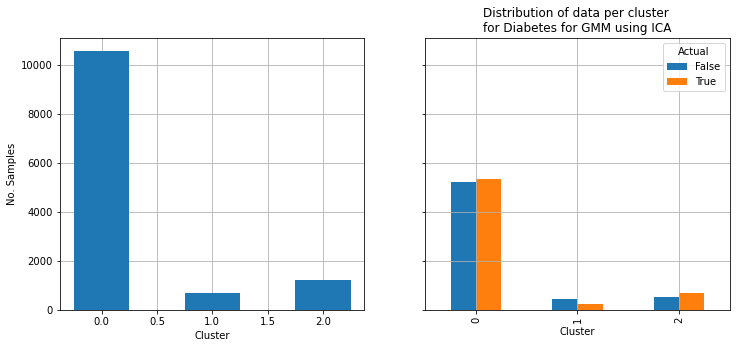

In [27]:
data_set = 'ICA'

best_gmm, bic = run_gmm(X_ICA)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_ICA, y, model_name, data_set, target_col)

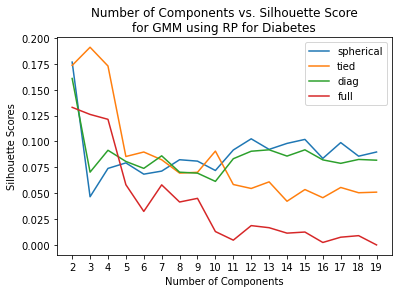

Silhouette score :  0.19118163766359994
AMI score        :  0.05043729007718591


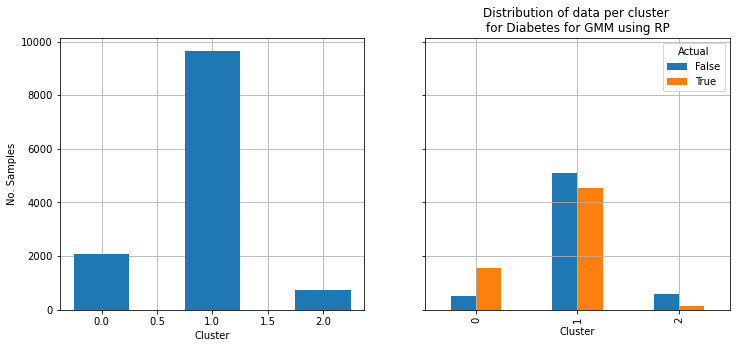

In [28]:
data_set = 'RP'

best_gmm, bic = run_gmm(X_RP)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_RP, y, model_name, data_set, target_col)

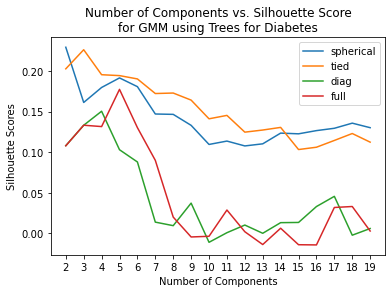

Silhouette score :  0.22939380874550383
AMI score        :  0.09571857545097481


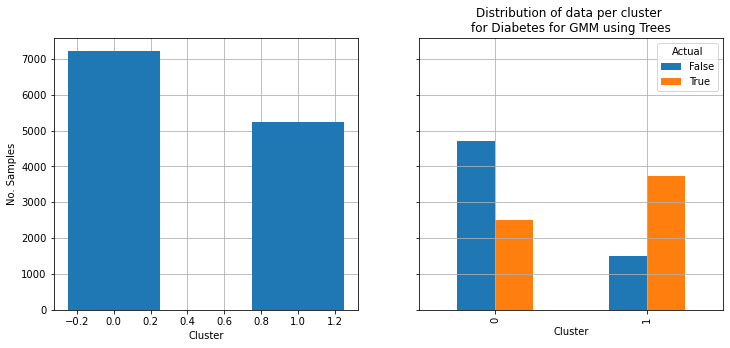

In [29]:
data_set = 'Trees'

best_gmm, bic = run_gmm(X_tree)
plot_bic(bic, model_name, data_set, target_col)
plot_cluster_dist(best_gmm, X_tree, y, model_name, data_set, target_col)